<a href="https://colab.research.google.com/github/nikitakol/HeartDiseasePrediction/blob/main/HeartDiseasePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pretext: This python notebooks depicts code that was mostly used in the final report. More analysis has been done in seperate notebooks and code has been cleaned ultimately.

## Handle imports

In [ ]:
# We had to run that command to import the library

!pip install pandas-summary 

In [ ]:
# Numpy and pandas to be used for data manipulation
import numpy as np
import pandas as pd
from pandas_summary import DataFrameSummary

# Pyplot to be used for data visualization (or alternatively seaborn)
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Scikit-learn classes
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score, roc_auc_score, precision_score, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

# Scikit-learn methods
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict, KFold, GridSearchCV
from sklearn.metrics import (plot_confusion_matrix, confusion_matrix, classification_report,
                             precision_score)
from sklearn.model_selection import RepeatedStratifiedKFold

# Preprocessing methods
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler

# Adding imports below in this same cell
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from time import time
import warnings

from tqdm import tqdm

# Confusion Matrix & Visualization Customization: 
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

blood = cm.get_cmap('gist_heat_r', 256)
blood = ListedColormap(blood(np.linspace(0.1, 0.8, 5)))

# Sharpio tests
from scipy.stats import shapiro
from scipy.stats import normaltest

# Misc
from time import time

## Import dataset and display information

In [ ]:
# Facilitating the uploading process of the file which had to be redone everytime when opening Google Colab

from google.colab import files
import os

if not os.path.exists('heart.csv'):
    files.upload()

df = pd.read_csv("heart.csv")

Saving heart.csv to heart.csv


In [ ]:
# General overview of the dataset

df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [ ]:
# General infos about the dataset

df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [ ]:
# Describe the attributes of type object

df.describe(include=object).T

,count,unique,top,freq
Sex,918,2,M,725
ChestPainType,918,4,ASY,496
RestingECG,918,3,Normal,552
ExerciseAngina,918,2,N,547
ST_Slope,918,3,Flat,460


In [ ]:
# See the different values for the objects

df["Sex"].value_counts()
df["ChestPainType"].value_counts()
df["RestingECG"].value_counts()
df["ExerciseAngina"].value_counts()
df["ST_Slope"].value_counts()

Flat    460
Up      395
Down     63
Name: ST_Slope, dtype: int64

## Data Understanding

### Searching for missing values and duplicates:


In [ ]:
# Checking for missing valus 

print('Number of Missing Values:', df.isnull().sum().sum())

# ...and for duplicates

print('Number of Duplicates:', len(df[df.duplicated()]))

Number of Missing Values: 0
Number of Duplicates: 0


###Searching and handling outliers: 

In [ ]:
# Outliers for Age

fig = px.box(df,y="Age", title=f"Distrubution of Age")
fig.show()

In [ ]:
# Outliers for Age dependent on HeartDisease

fig = px.box(df,y="Age",x="HeartDisease",title=f"Distrubution of Age")
fig.show()

In [ ]:
# Outliers for Resting Blood Pressure

fig = px.box(df,y="RestingBP", title=f"Distrubution of RestingBP")
fig.show()

In [ ]:
# Outliers for Resting Blood Pressure dependent on HeartDisease and Sex

fig = px.box(df,y="RestingBP",x="HeartDisease",title=f"Distrubution of RestingBP",color="Sex")
fig.show()

In [ ]:
# Since a RestingBP is medically impossible, this patient is invalid and gets removed: 
df = df.drop(df[(df['RestingBP'] == 0)].index)

# The rest of the outliers is balanced with median imputation:
q1 = df['RestingBP'].quantile(0.25)
q3 = df['RestingBP'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr

RBPmedian = np.median(df['RestingBP'])
for i in df['RestingBP']:
    if i > Upper_tail or i < Lower_tail:
            df['RestingBP'] = df['RestingBP'].replace(i, RBPmedian)

In [ ]:
# Outliers for Cholesterol: 

fig = px.box(df,y="Cholesterol", title=f"Distrubution of Cholesterol")
fig.show()

In [ ]:
# Outliers for Cholesterol dependent on HeartDisease: 

fig = px.box(df,y="Cholesterol",x="HeartDisease",title=f"Distrubution of Cholesterol")
fig.show()

In [ ]:
# Median imputation just on upper tail
q1 = df['Cholesterol'].quantile(0.25)
q3 = df['Cholesterol'].quantile(0.75)
iqr = q3-q1
Upper_tail = q3 + 1.5 * iqr

CHmed = np.median(df['Cholesterol'])
for i in df['Cholesterol']:
    if i > Upper_tail:
            df['Cholesterol'] = df['Cholesterol'].replace(i, CHmed)

In [ ]:
# Outliers for MaxHR

fig = px.box(df,y="MaxHR", title=f"Distrubution of MaxHR")
fig.show()

In [ ]:
# Outliers for MaxHR dependent on HeartDisease

fig = px.box(df,y="MaxHR",x="HeartDisease",title=f"Distrubution of MaxHR")
fig.show()

No action is taken on MaxHR since its only two, not very significant outliers

In [ ]:
# Outliers for Oldpeak

fig = px.box(df,y="Oldpeak", title=f"Distrubution of Oldpeak")
fig.show()

In [ ]:
# Outliers for Oldpeak dependent on HeartDisease

fig = px.box(df,y="Oldpeak",x="HeartDisease",title=f"Distrubution of Oldpeak")
fig.show()

Since the strongest outliers (as seen in first graph regarding oldpeak) are related to heart disease (as seen in second graph regarding oldpeak), no action is taken on removing these instances since they tell us a lot of relevant information, apparently. 

In [ ]:
df.shape

(917, 12)

Since further data processing would add a complexitiy to visualizing the data, we will first perform voisualizations before moving on with preprocessing the data to use it for modeling. 

### Data visualizations

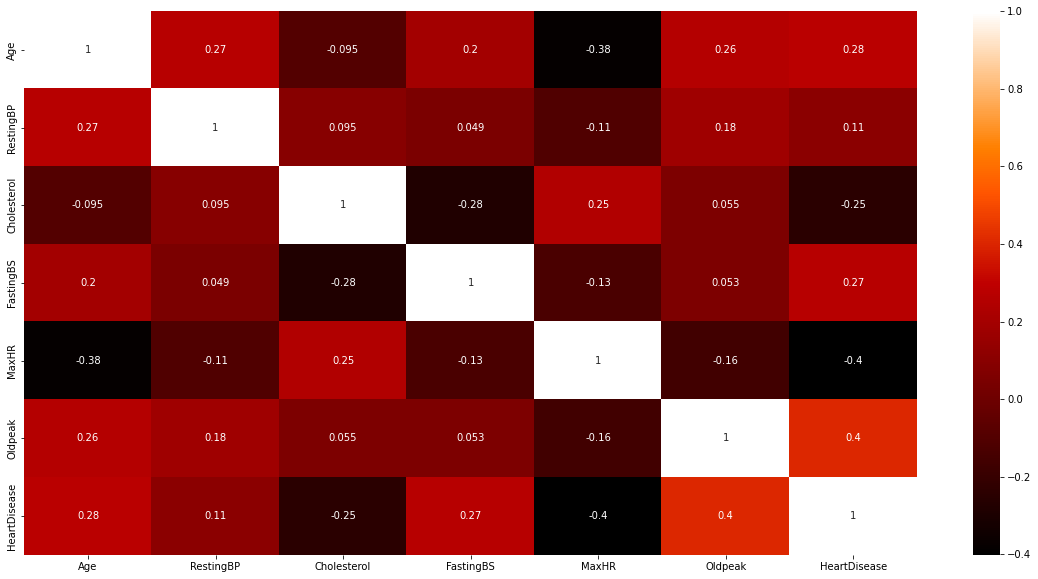

In [ ]:
# Plotting heat map

plt.figure(figsize=(20,10))

sns.heatmap(df.corr(),annot=True,cmap="gist_heat")

In [ ]:
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('fivethirtyeight')
sns.set(font_scale = 1)  
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [ ]:
# Preparing the visualization of the numerical features

df_info = DataFrameSummary(df)

dtype = pd.DataFrame(df_info.summary().loc['types'] == 'numeric')
num_cols = dtype[dtype['types'] == True].index.to_list()
num_cols

['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

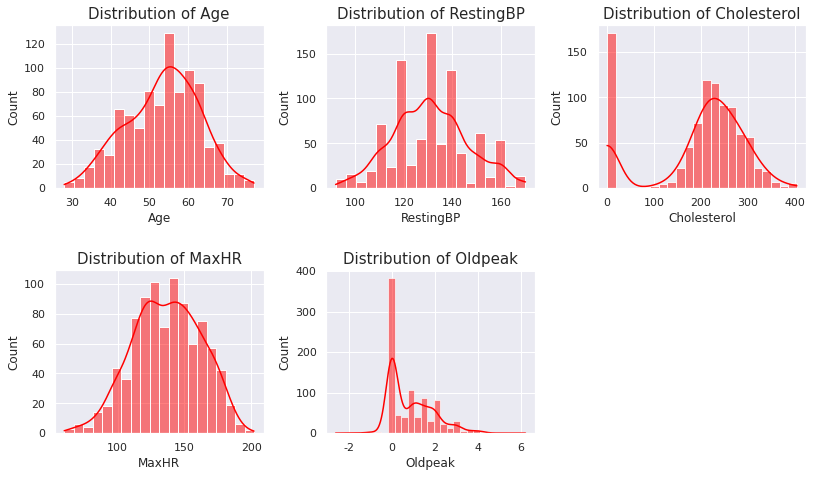

In [ ]:
# Plotting numerical features

fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (12, 7))
axes = axes.flatten()

for col, ax in zip(num_cols, axes):
    ax = sns.histplot(data = df, x = col, ax = ax, kde = True, color = 'red')
    ax.set_title(f"Distribution of {col}", fontsize=15)
    plt.subplots_adjust(hspace=0.5, wspace=0.3)

axes[-1].axis('off')
plt.show()

In [ ]:
# Preparing visulizations of categorical features

cat_cols = list(set(df.columns) - set(num_cols))
cat_cols.remove('HeartDisease')

cat_cols

['ST_Slope',
 'FastingBS',
 'ChestPainType',
 'RestingECG',
 'Sex',
 'ExerciseAngina']

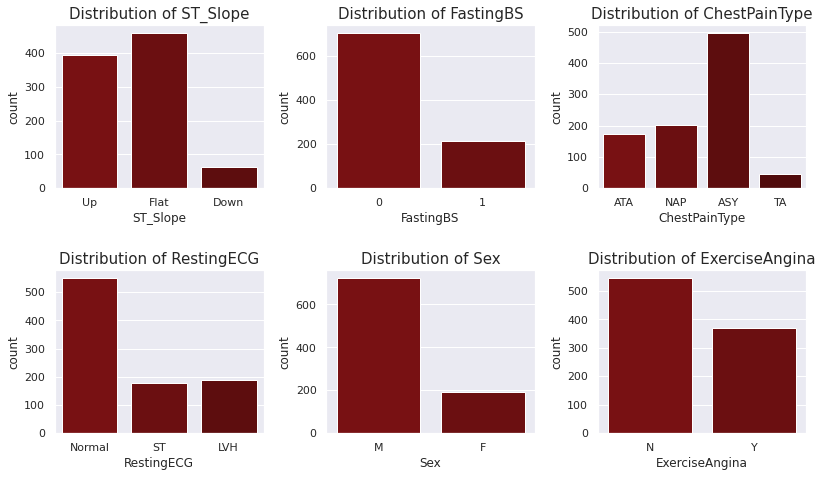

In [ ]:
# Plotting numerical features

fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (12, 7))
axes = axes.flatten()

for col, ax in zip(cat_cols, axes):
    ax = sns.countplot(data = df, x = col, ax = ax, palette=[('#890002'), ('#7a0002'), ('#6a0001'), ('#5b0001'), ('#4c0001'), ('#3d0001'), ('#2e0001'), ('#1e0000'), ('#0f0000'), ('#000000')]) #others to try: 'rocket_r', 'YlOrBr_r', 'dark:salmon'
    ax.set_title(f"Distribution of {col}", fontsize=15)
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    
plt.show()

Text(0.5, 1.0, '')

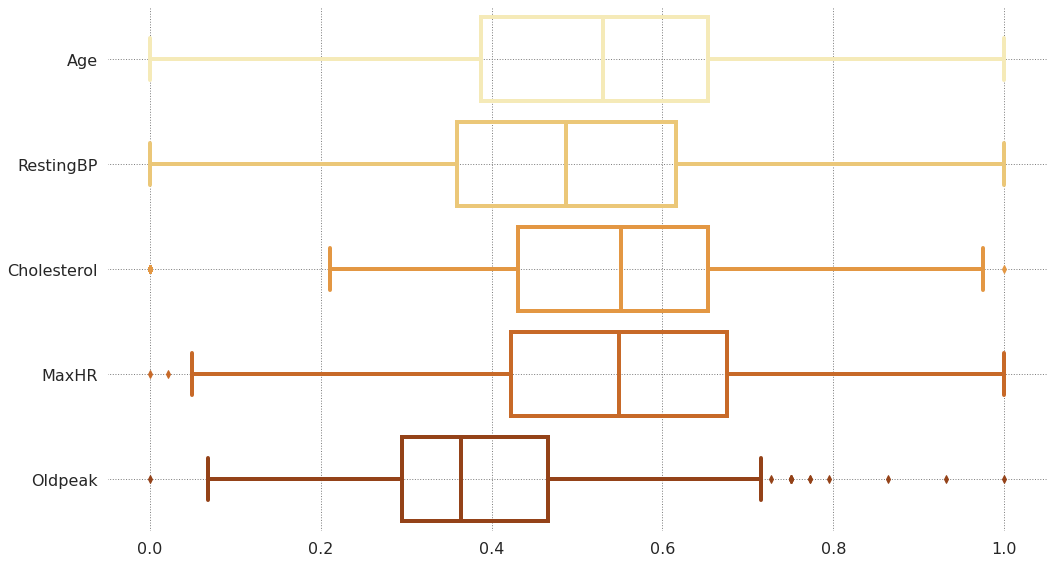

In [ ]:
# Plotting outliers together in one graph in a scaled format

df1 = df[:]

for col in num_cols:
    df1[col] = MinMaxScaler().fit_transform(df1[[col]])

df1 = df1.drop(axis=1, labels=['Sex', 'ChestPainType', 'FastingBS', 
                               'RestingECG', 'ExerciseAngina', 'ST_Slope',
                               'HeartDisease'])

fig, ax = plt.subplots(figsize =(15,9))
ax.patch.set_facecolor('#ffffff')
fig.patch.set_facecolor('#ffffff')
mpl.rcParams['font.family'] = 'TeX Gyre Heros'

sns.boxplot(data = df1, ax=ax, palette='YlOrBr', orient="h", linewidth=4);

for i,artist in enumerate(ax.artists):
    col = artist.get_facecolor()
    artist.set_edgecolor(col)
    artist.set_facecolor('None')
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

for i in ['top', 'bottom', 'left', 'right']:
    ax.spines[i].set_visible(True)

ax.grid(True, color='grey', ls =':')

plt.xticks(fontsize=16);
plt.yticks(fontsize=16);

ax.set_title('')

findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.
findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.
findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.


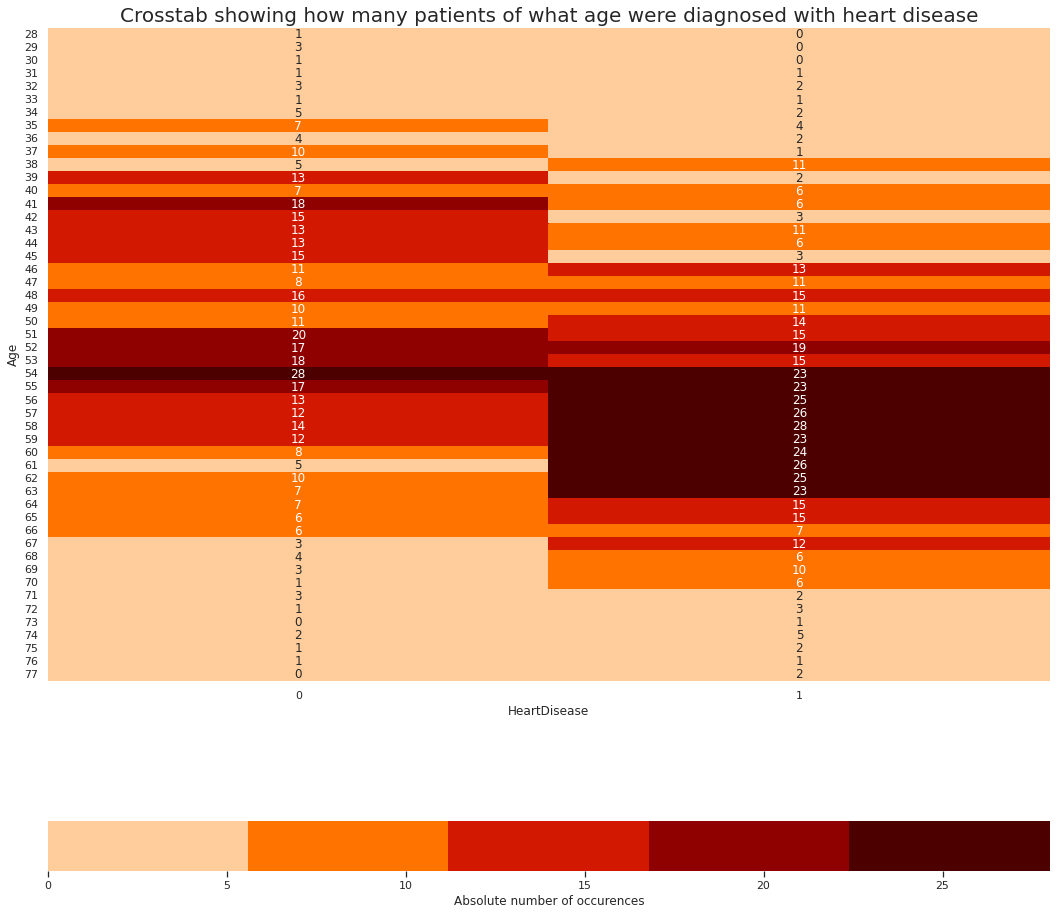

In [ ]:
# Plotting a Crosstab

ct = pd.crosstab(df["Age"], df["HeartDisease"]) 

plt.figure(figsize = (16, 16))
plt.title("Crosstab showing how many patients of what age were diagnosed with heart disease", fontsize = 20)
sns.heatmap(ct, cmap = blood, annot = True, cbar = True, fmt = "g", cbar_kws={'label': 'Absolute number of occurences', 'orientation': 'horizontal'})

###Data Distribution Check

In order to do Data Scaling the right way, we check the numerical data for gaussian distribution. If gaussian distribution is given, standardization is mostly beneficial. If not, normalization is beneficial. 

In [ ]:
# Shapiro Test 

print("")
print("Shapiro Test:")
print("")

stat, p = shapiro(df['Age'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
 print('Age Sample looks Gaussian (fail to reject H0)')
else:
 print('Age Sample does not look Gaussian (reject H0)')

print("")
stat, p = shapiro(df['RestingBP'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
 print('RestingBP Sample looks Gaussian (fail to reject H0)')
else:
 print('RestingBP Sample does not look Gaussian (reject H0)')

print("")
stat, p = shapiro(df['Cholesterol'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
 print('Cholesterol Sample looks Gaussian (fail to reject H0)')
else:
 print('Cholesterol Sample does not look Gaussian (reject H0)')

 print("")
stat, p = shapiro(df['MaxHR'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
 print('MaxHR Sample looks Gaussian (fail to reject H0)')
else:
 print('MaxHR Sample does not look Gaussian (reject H0)')

 print("")
stat, p = shapiro(df['Oldpeak'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
 print('Oldpeak Sample looks Gaussian (fail to reject H0)')
else:
 print('Oldpeak Sample does not look Gaussian (reject H0)')

# D’Agostino’s K² Test

print("")
print("D’Agostino’s K² Test:")
print("")
stat, p = normaltest(df['Age'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
 print('Age Sample looks Gaussian (fail to reject H0)')
else:
 print('Age Sample does not look Gaussian (reject H0)')

 print("")
stat, p = normaltest(df['RestingBP'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
 print('RestingBP Sample looks Gaussian (fail to reject H0)')
else:
 print('RestingBP Sample does not look Gaussian (reject H0)')

 print("")
stat, p = normaltest(df['Cholesterol'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
 print('Cholesterol Sample looks Gaussian (fail to reject H0)')
else:
 print('Cholesterol Sample does not look Gaussian (reject H0)')

print("")
stat, p = normaltest(df['MaxHR'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
 print('MaxHR Sample looks Gaussian (fail to reject H0)')
else:
 print('MaxHR Sample does not look Gaussian (reject H0)')

 print("")
stat, p = normaltest(df['Oldpeak'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
 print('Oldpeak Sample looks Gaussian (fail to reject H0)')
else:
 print('Oldpeak Sample does not look Gaussian (reject H0)')



Shapiro Test:

Statistics=0.991, p=0.000
Age Sample does not look Gaussian (reject H0)

Statistics=0.983, p=0.000
RestingBP Sample does not look Gaussian (reject H0)

Statistics=0.847, p=0.000
Cholesterol Sample does not look Gaussian (reject H0)

Statistics=0.993, p=0.000
MaxHR Sample does not look Gaussian (reject H0)

Statistics=0.860, p=0.000
Oldpeak Sample does not look Gaussian (reject H0)

D’Agostino’s K² Test:

Statistics=14.498, p=0.001
Age Sample does not look Gaussian (reject H0)

Statistics=7.487, p=0.024
RestingBP Sample does not look Gaussian (reject H0)

Statistics=96.915, p=0.000
Cholesterol Sample does not look Gaussian (reject H0)

Statistics=15.782, p=0.000
MaxHR Sample does not look Gaussian (reject H0)

Statistics=139.218, p=0.000
Oldpeak Sample does not look Gaussian (reject H0)


Data is not gaussian normally distributed: Hence, we will use MinMaxScaling (Normalization) to preprocess data for the kNN and logistic Regression. 

Now, further data preprocessing can be done before modeling the algorithms. 

###Data Encoding

We chose to proceed with One-Hot Encoding after trying out both and agreeing on one approach to reduce model complexity and increase comparability

In [ ]:
# One-Hot Encoding (dummies)

df_nt = pd.get_dummies(df)
df_nt.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,1,0,0,0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,1
3,48,138,214,0,108,1.5,1,1,0,1,0,0,0,0,1,0,0,1,0,1,0
4,54,150,195,0,122,0.0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1


### Data Splitting (Test and Train set)

We first split the dataframe into a dependent and independent variable (set). Hereinafter, a datasplit into a training and test data is performed.

In [ ]:
y, X = df_nt['HeartDisease'], df_nt.drop(columns='HeartDisease')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Modeling

##Baseline

A baseline based on a majority and random DummyClassifier is created to evaluate modeling performance. 

In [ ]:
#Baseline with a DummyClassifier with a Majority Rule

dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_most_frequent = dummy_majority.predict(X_test)
print("Unique predicted labels: {}".format(np.unique(pred_most_frequent)))
print("Majority dummy score: {:.4f}".format(dummy_majority.score(X_test, y_test)))

# Baseline with a randomized DummyClassifier

dummy = DummyClassifier(strategy='uniform').fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)
print("Random dummy score: {:.4f}".format(dummy.score(X_test, y_test)))

Unique predicted labels: [1]
Majority dummy score: 0.6413
Random dummy score: 0.5000


Given that the random classifier varies in scores and the fact that the majority-based algorithm mostly scores a higher accuracy, we use it for our report and as a baseline for subsequent modeling.

In [ ]:
# Print out all scores of DummyClassifier

print('Accuracy score: ', round(accuracy_score(y_test, pred_most_frequent), 4))
print('F1 Score: ', round(f1_score(y_test, pred_most_frequent), 4))
print('Recall score: ', round(recall_score(y_test, pred_most_frequent), 4))
print('Precision Score: ', round(roc_auc_score(y_test, pred_most_frequent), 4))

Accuracy score:  0.6413
F1 Score:  0.7815
Recall score:  1.0
Precision Score:  0.5


The fact that the dummy classifier at use always predicts "1" makes it´s recall and precision score inconclusive. Hence, for comparing our models with the baseline model, we will use the accuracy score regardless of our focus on optimizin the models towards recall. The following confusion matrix confirms this approach: 

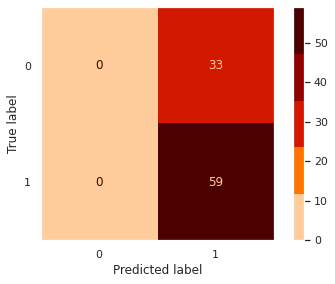

In [ ]:
# Confusion Matrix for the baseline model - not used in the report but left in the code for reference

plot_confusion_matrix(dummy_majority, X_test, y_test,cmap=blood , values_format='d')
plt.grid(False)

Metrics to measure model performance: 
- **Accuracy** is the number of correct predictions (TP and TN) divided by the number of all samples (all entries of the confusion matrix summed up)
- **Precision** measures how many of the samples predicted as positive are actually positive (Precision is used as a performance metric when the goal is to limit the number of false positives)
- **Recall** measures how many of the positive samples are captured by the positive predictions (Recall is used as performance metric when we need to identify all positive samples; that is, when it is important to avoid false negatives) 
- **f-score** is  the harmonic mean of precision and recall (combination of both)

## kNN Classifier

In [ ]:
# Feature scaling with MinMaxScaler() for kNN & Logistic Regression

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# First model

knn = KNeighborsClassifier() #default
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 4))
print('F1 Score: ', round(f1_score(y_test, y_pred), 4))
print('Recall score: ', round(recall_score(y_test, y_pred), 4))
print('Precision Score: ', round(roc_auc_score(y_test, y_pred), 4))

Accuracy score:  0.8804
F1 Score:  0.9043
Recall score:  0.8814
Precision Score:  0.8801


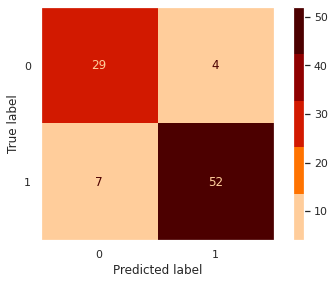

In [ ]:
# Confusion matrix basic - again left in the report for the sake of reference

knn = KNeighborsClassifier()
knn = knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=blood, values_format='d')
plt.grid(False)

### Elbow Method (using recall score)

In [ ]:
# Elbow method was used to "validate" GridSearchCV

test_error_rates = []

for k in range(1, 50):
    KNN_model = KNeighborsClassifier(n_neighbors=k)
    KNN_model.fit(X_train_scaled, y_train) 
   
    y_test_pred = KNN_model.predict(X_test_scaled)
    
    test_error = 1 - recall_score(y_test, y_test_pred)
    test_error_rates.append(test_error)

Text(0, 0.5, 'Error Rate')

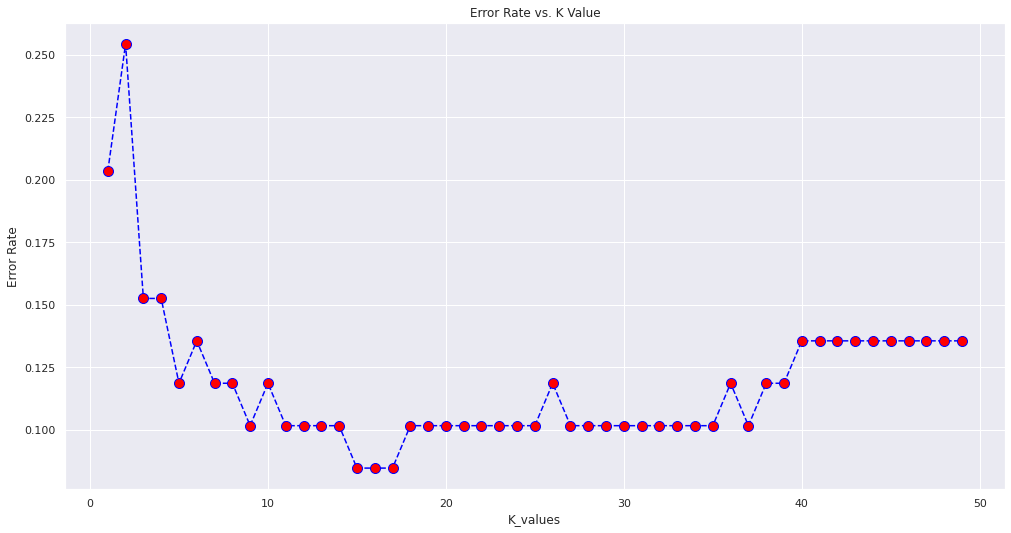

In [ ]:
# Plotting elbow method

plt.figure(figsize=(15, 8))
plt.plot(range(1, 50), test_error_rates, color='blue', linestyle='--', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K_values')
plt.ylabel('Error Rate')

In [ ]:
# Manually checking error scores

test_error_rates = []

for k in range(15, 18):
    KNN_model = KNeighborsClassifier(n_neighbors=k)
    KNN_model.fit(X_train_scaled, y_train) 
   
    y_test_pred = KNN_model.predict(X_test_scaled)
    
    test_error = 1 - accuracy_score(y_test, y_test_pred)
    print(k,":", test_error)

15 : 0.08695652173913049
16 : 0.08695652173913049
17 : 0.08695652173913049


### GridSearchCV

In [ ]:
k_values= range(1, 30)
param_grid = {"n_neighbors": k_values, "p": [1, 2], "weights": ['uniform', "distance"]}

In [ ]:
KNN_grid = KNeighborsClassifier()

In [ ]:
KNN_grid_model = GridSearchCV(KNN_grid, param_grid, cv=10, scoring='recall')

In [ ]:
KNN_grid_model.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 30), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='recall')

In [ ]:
print(KNN_grid_model.best_params_) # result in line with GridSearchCV

{'n_neighbors': 16, 'p': 1, 'weights': 'distance'}


In [ ]:
# Parameters for optimzed model

KNN_model = KNeighborsClassifier(n_neighbors=16, p=1, weights = "distance")
KNN_model.fit(X_train, y_train)
y_pred = KNN_model.predict(X_test)
y_train_pred = KNN_model.predict(X_train)

Accuracy score:  0.913
F1 Score:  0.931
Recall score:  0.9153
Precision Score:  0.9122


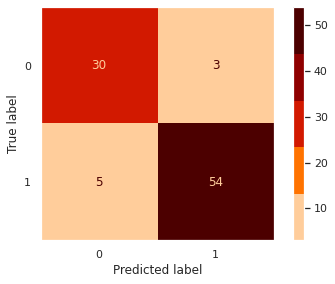

In [ ]:
# Confusion Matrix GsCV 

KNN_model = KNeighborsClassifier(n_neighbors=16, p=1, weights = "distance")
KNN_model.fit(X_train_scaled, y_train)
y_pred = KNN_model.predict(X_test_scaled)

print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 4))
print('F1 Score: ', round(f1_score(y_test, y_pred), 4))
print('Recall score: ', round(recall_score(y_test, y_pred), 4))
print('Precision Score: ', round(roc_auc_score(y_test, y_pred), 4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=blood, values_format='d')
plt.grid(False)

##Logistic Regression Classifier 

###Data Scaling (model-specific preprocessing)

Before performing Log-Regression we need to do data scaling or standardization. Similar to kNN, given the non-gaussian distribution of features, we use MinMaxScaling to normalize the data. 

###Standard Logistic Regression

In [ ]:
# Standard logistic regression

lr = LogisticRegression(solver = 'liblinear')
lr.fit(X_train_scaled, y_train)

# Predicting and comparing scores for the basic model

y_pred = lr.predict(X_test_scaled)
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 4))
print('Precision Score: ', round(roc_auc_score(y_test, y_pred), 4))
print('Recall Score: ', round(recall_score(y_test, y_pred), 4))
print('F1 Score: ', round(f1_score(y_test, y_pred), 4))
print("")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy score:  0.8804
Precision Score:  0.8801
Recall Score:  0.8814
F1 Score:  0.9043

Confusion Matrix:
[[29  4]
 [ 7 52]]


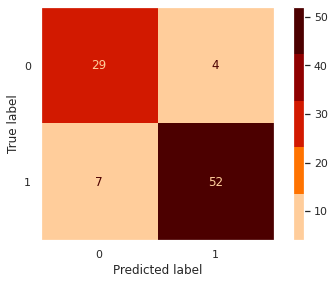

In [ ]:
# Confusion Matrix basic model

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=blood, values_format='d')
plt.grid(False)

###GridSearchCV on Logistic Regression

Tuning C and Penalty as attributes, scoring for recall

In [ ]:
# Defining the grid for GridSearchCV

lr_params ={"C":[0.00000000000000000000001, 0.0000000000000001, 0.000000000000001, 0.0000000001, 0.0000001, 0.00001,
                 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 
            "penalty":["l1","l2"]}

# GridSearchCV on lr with recall as scoring

lr_gscv=GridSearchCV(lr,lr_params,cv=10, scoring = 'recall')
lr_gscv.fit(X_train_scaled,y_train)

# Performance on test set

print("Test set score: {:.4f}".format(lr_gscv.score(X_test_scaled, y_test)))
print("Best parameters: {}".format(lr_gscv.best_params_))
print("Best cross-validation score: {:.4f}".format(lr_gscv.best_score_))

print("")
y_gscv_pred = lr_gscv.best_estimator_.predict(X_test_scaled)
print('Accuracy score: ', round(accuracy_score(y_test, y_gscv_pred), 4))
print('F1 Score: ', round(f1_score(y_test, y_gscv_pred), 4))
print('Precision Score: ', round(roc_auc_score(y_test, y_gscv_pred), 4))
print('Recall Score: ', round(recall_score(y_test, y_gscv_pred), 4))
print("")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_gscv_pred))
print("")
print("Best Estimator :(complete set) ",lr_gscv.best_estimator_)
print("Tuned hyperparameters :(best parameters) ",lr_gscv.best_params_)

Test set score: 0.9492
Best parameters: {'C': 1e-15, 'penalty': 'l2'}
Best cross-validation score: 0.9687

Accuracy score:  0.8587
F1 Score:  0.896
Precision Score:  0.8231
Recall Score:  0.9492

Confusion Matrix:
[[23 10]
 [ 3 56]]

Best Estimator :(complete set)  LogisticRegression(C=1e-15, solver='liblinear')
Tuned hyperparameters :(best parameters)  {'C': 1e-15, 'penalty': 'l2'}


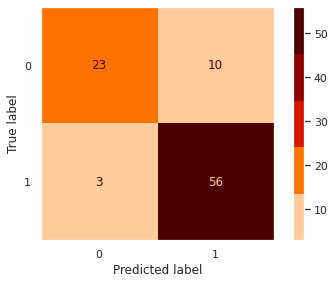

In [ ]:
# Confusion Matrix after GridSearchCV

ConfusionMatrixDisplay.from_predictions(y_test, y_gscv_pred, cmap=blood, values_format='d')
plt.grid(False)

##Random Forest Classifier

### Standard random forest classifier

In [ ]:
# Standard random forest classifier

rf_clf = RandomForestClassifier(n_estimators=10, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

print("\nAccuracy score : {:.4f}".format(accuracy_score(y_test, y_pred)))
print("\nF1 score : {:.4f}".format(f1_score(y_test, y_pred)))
print("\nPrecision score : {:.4f}".format(roc_auc_score(y_test, y_pred)))
print("\nRecall score : {:.4f}".format(recall_score(y_test, y_pred)))

In [ ]:
# Basic Confusion Matrix

rf_clf = RandomForestClassifier(n_estimators=10, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=blood, values_format='d')
plt.grid(False)

### GridSearchCV on random forest classifier

In [ ]:
rf = RandomForestClassifier(random_state=42)

n_estimators = [10, 25, 50, 100, 200]
max_features = ['auto', 'sqrt']
max_depth = [5, 10, 20, 40]
max_leaf_nodes = [5, 10, 20, 40]
min_samples_split = [6, 8, 10]

param_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'max_leaf_nodes': max_leaf_nodes,
    'min_samples_split': min_samples_split
}

start = time()
rf_gscv = GridSearchCV(rf, param_grid=param_grid, cv=10, n_jobs=-1, scoring='recall')
rf_gscv.fit(X_train, y_train)
rf_gscv_pred = rf_gscv.best_estimator_.predict(X_test)

print("Accuracy score: {:.4f}".format(accuracy_score(y_test, rf_gscv_pred)))
print("F1 score: {:.4f}".format(f1_score(y_test, rf_gscv_pred)))
print("Precision score: {:.4f}".format(roc_auc_score(y_test, rf_gscv_pred)))
print("Recall score: {:.4f}".format(recall_score(y_test, rf_gscv_pred)))
print("Execution time: {:.2f} seconds".format(time() - start))

In [ ]:
print("Best score: {:.4f}\nBest params: {}".format(rf_gscv.best_score_, rf_gscv.best_params_))
print("Best estimator: {}".format(rf_gscv.best_estimator_))

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, rf_gscv_pred, cmap=blood, values_format='d')
plt.grid(False)

##Naive Bayes Classifier

####Standard Gaussian Naive Bayes

In [ ]:
# Build Model on Training Data

gnb = GaussianNB().fit(X_train, y_train)

# To train the model on training data so it can accurately predict the outcome.

# Predict Testing Data

y_pred = gnb.predict(X_test)

# To obtain model prediction on testing data to evaluate the model’s accuracy and efficiency.

# Classification Report

print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 4))
print('F1 Score: ', round(f1_score(y_test, y_pred), 4))
print('Precision Score: ', round(roc_auc_score(y_test, y_pred), 4))
print('Recall Score: ', round(recall_score(y_test, y_pred), 4))
print("\nConfusion matrix : \n {}".format(confusion_matrix(y_test, y_pred)))

Accuracy score:  0.8152
F1 Score:  0.8496
Precision Score:  0.8159
Recall Score:  0.8136

Confusion matrix : 
 [[27  6]
 [11 48]]


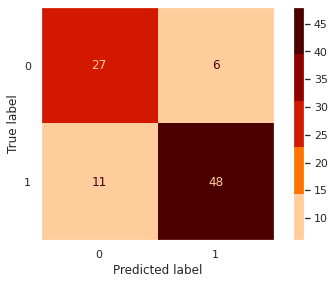

In [ ]:
# Confusion Matrix basic model

ConfusionMatrixDisplay.from_estimator(gnb, X_test, y_test, cmap=blood, values_format='d')
plt.grid(False)

####GridSearchCV Gaussian Naive Bayes

In [ ]:
# Define Grid Search Parameters

gnb_params = {
'var_smoothing': np.logspace(0,-9, num=100)
}

# Hyperparameter Tune Using Training Data

gnb_cv = GridSearchCV(gnb, gnb_params, cv=10, scoring='recall').fit(X_train, y_train)

# Predict Testing Data

y_gnbcv_pred = gnb_cv.best_estimator_.predict(X_test)

# To obtain model prediction on testing data to evaluate the model’s accuracy and efficiency.

# Numeric Analysis
print(confusion_matrix(y_test, y_gnbcv_pred), ": is the confusion matrix")
print("")

print('Accuracy score: ', round(accuracy_score(y_test, y_gnbcv_pred), 4))
print('F1 Score: ', round(f1_score(y_test, y_gnbcv_pred), 4))
print('Precision Score: ', round(roc_auc_score(y_test, y_gnbcv_pred), 4))
print('Recall Score: ', round(recall_score(y_test, y_gnbcv_pred), 4))
print("")

print("Best Estimator :(complete set) ",gnb_cv.best_estimator_)
print("Tuned hyperparameters :(best parameters) ",gnb_cv.best_params_)

[[28  5]
 [ 7 52]] : is the confusion matrix

Accuracy score:  0.8696
F1 Score:  0.8966
Precision Score:  0.8649
Recall Score:  0.8814

Best Estimator :(complete set)  GaussianNB(var_smoothing=1e-05)
Tuned hyperparameters :(best parameters)  {'var_smoothing': 1e-05}


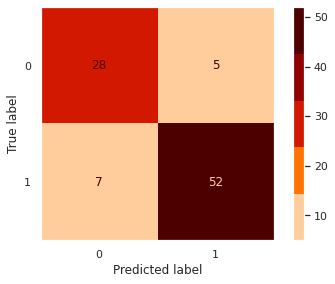

In [ ]:
# Confusion Matrix tuned model

ConfusionMatrixDisplay.from_estimator(gnb_cv, X_test, y_test, cmap=blood, values_format='d')
plt.grid(False)

Why Smoothing?

To set the selected parameters used to find the optimal combination.
*   var_smoothing: a stability calculation to widen (or smooth) the curve and therefore account for more samples that are further away from the distribution mean. 


Defining Hyperparameters
*   gnb is the machine learning model of interest, provided the model has a scoring function; in this case, the model assigned is GaussianNB().
*   gnb_params is a dictionary with parameters names (string) as keys and lists of parameter settings to try as values; this enables searching over any sequence of parameter settings.
*   cv is the cross-validation generator or an iterable, in this case, there is a 10-fold cross-validation.

To find an optimal combination of hyperparameters that minimizes a predefined loss function to give better results.



